https://www.kaggle.com/c/santas-stolen-sleigh/overview

dist（北極からA）*（ウェイトA +ウェイトB + base_weight）+

dist（AからB）*（重みB + base_weight）+

dist（Bから北極）*（base_weight）

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import pathlib
from tqdm import tqdm
from itertools import product

pd.options.display.max_columns = 500

In [2]:
data_path = pathlib.Path('data')
file_gifts = data_path / 'input/gifts.csv'

In [3]:
df_gifts = pd.read_csv(file_gifts)
df_gifts.shape

(100000, 4)

In [4]:
df_gifts.head(1)

,GiftId,Latitude,Longitude,Weight
0,1,16.345769,6.303545,1.0


In [5]:
df_gifts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   GiftId     100000 non-null  int64  
 1   Latitude   100000 non-null  float64
 2   Longitude  100000 non-null  float64
 3   Weight     100000 non-null  float64
dtypes: float64(3), int64(1)
memory usage: 3.1 MB


In [6]:
df_gifts.isnull().sum()

GiftId       0
Latitude     0
Longitude    0
Weight       0
dtype: int64

## 基礎分析

In [7]:
df_gifts.describe()

,GiftId,Latitude,Longitude,Weight
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,50000.500000,13.205598,18.641597,14.098391
std,28867.657797,43.692450,82.521346,14.080697
min,1.000000,-89.993021,-179.976102,1.000000
25%,25000.750000,-12.184954,-58.112734,1.000000
50%,50000.500000,23.074852,26.527349,10.013013
75%,75000.250000,47.051352,87.389918,23.465783
max,100000.000000,83.408546,179.985036,50.000000


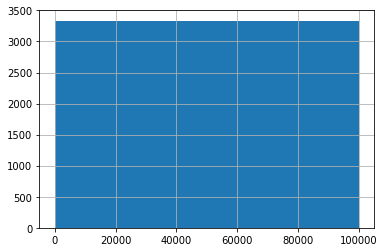

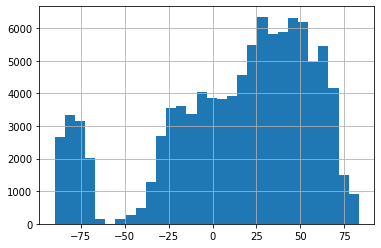

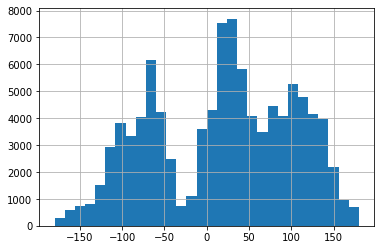

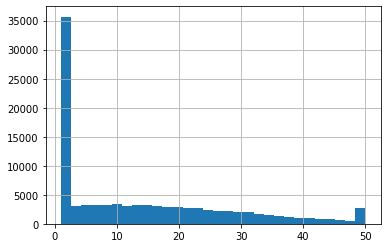

<Figure size 432x288 with 0 Axes>

In [8]:
for col in df_gifts.columns:
    df_gifts[col].hist(bins=30)
    plt.show()
    plt.clf()

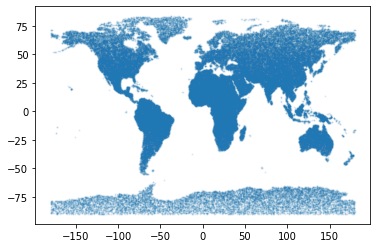

In [9]:
plt.scatter(df_gifts.Longitude, df_gifts.Latitude, s=1, alpha=.1)
# 南極に住んでる子供多すぎないか

## clustering

In [10]:
from sklearn.cluster import KMeans
num_cluster = 50
clf = KMeans(n_clusters=num_cluster, random_state=0)
clf.fit(df_gifts[['Latitude', 'Longitude']])

df_gifts['labels'] = clf.labels_

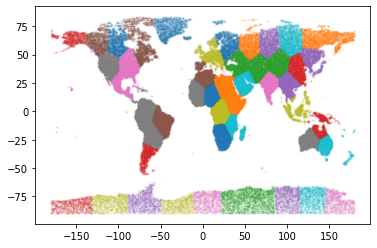

In [128]:
fig, ax = plt.subplots()

for i in df_gifts.labels.unique():
    ax.scatter(
        df_gifts.loc[df_gifts.labels==i, 'Longitude'],
        df_gifts.loc[df_gifts.labels==i, 'Latitude'],
        s=1, alpha=.1
    )

plt.show()

In [129]:
df_gifts.labels.value_counts().describe()

count      50.000000
mean     2000.000000
std       686.329991
min       843.000000
25%      1380.750000
50%      1995.500000
75%      2560.750000
max      3863.000000
Name: labels, dtype: float64

In [130]:
labels_weight = df_gifts.groupby('labels').Weight.sum().to_frame()
labels_weight.describe()

,Weight
count,50.000000
mean,28196.781960
std,9632.095216
min,11606.544354
25%,19461.103604
50%,28602.024924
75%,35967.575700
max,53811.865931


In [131]:
(labels_weight > 30000).sum()

Weight    22
dtype: int64

In [132]:
reclust = labels_weight.query('Weight > 30000').index
reclust

Int64Index([ 0,  1,  3,  9, 11, 12, 18, 19, 20, 21, 24, 31, 34, 35, 36, 37, 38,
            40, 45, 46, 47, 49],
           dtype='int64', name='labels')

In [133]:
for label in reclust:
    data = df_gifts.query('labels==@label')
    num_cluster = 2
    clf = KMeans(n_clusters=num_cluster, random_state=0)
    clf.fit(data[['Latitude', 'Longitude']])

    df_gifts.loc[data.index, 'labels'] = [f'{label}_{newlabel}' for newlabel in clf.labels_]

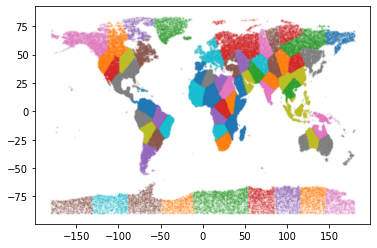

In [134]:
fig, ax = plt.subplots()

for i in df_gifts.labels.unique():
    ax.scatter(
        df_gifts.loc[df_gifts.labels==i, 'Longitude'],
        df_gifts.loc[df_gifts.labels==i, 'Latitude'],
        s=1, alpha=.1
    )

plt.show()

In [135]:
df_gifts.labels.value_counts().describe()

count      72.000000
mean     1388.888889
std       301.918399
min       843.000000
25%      1183.750000
50%      1328.500000
75%      1525.000000
max      2069.000000
Name: labels, dtype: float64

In [136]:
df_gifts.groupby('labels').Weight.sum().describe()

count       72.000000
mean     19581.098584
std       4290.381068
min      11606.544354
25%      16814.794380
50%      18471.337467
75%      21234.906483
max      29742.351250
Name: Weight, dtype: float64

## (dbscan)

## binpacking

In [137]:
df_gifts.Weight.sum() / 1000

1409.839098020728

In [138]:
from binpacking_solver import binpacking_solver
import warnings
warnings.simplefilter('ignore')

group_data_list = []
for i, label in enumerate(df_gifts.labels.unique()):
    print(f'\n\n------ {i}: {label} -----')
    data = binpacking_solver(df_gifts.query('labels==@label'))
    group_data_list.append(data)



------ 0: 12_1 -----
出力先：binpacking/20200506025636
gift num: 1192
total weight: 16773.086571701642
num_groups: 19
最適化実行中
opt_time:  3.173497438430786
status:  Optimal
目的関数:  17.0
Gift数 要約統計量
count     17.000000
mean      70.117647
std       24.601530
min       23.000000
25%       53.000000
50%       65.000000
75%       99.000000
max      100.000000
Name: group, dtype: float64

グループのWeight合計 要約統計量
count     17.000000
mean     986.652151
std       13.273447
min      950.791520
25%      980.432925
50%      989.471192
75%      996.600959
max      999.736025
Name: Weight, dtype: float64


------ 1: 35_1 -----
出力先：binpacking/20200506025644
gift num: 1481
total weight: 20987.58409182647
num_groups: 24
最適化実行中
opt_time:  3601.529716730118
status:  Optimal
目的関数:  24.0
Gift数 要約統計量
count    24.000000
mean     61.708333
std      10.576755
min      41.000000
25%      56.000000
50%      61.000000
75%      66.500000
max      82.000000
Name: group, dtype: float64

グループのWeight合計 要約統計量
count     24.000

Name: Weight, dtype: float64


------ 28: 37_1 -----
出力先：binpacking/20200506053616
gift num: 1478
total weight: 21001.10500525085
num_groups: 24
最適化実行中
opt_time:  11.972341775894165
status:  Optimal
目的関数:  22.0
Gift数 要約統計量
count     22.000000
mean      67.181818
std       20.532521
min       26.000000
25%       52.750000
50%       60.500000
75%       81.750000
max      100.000000
Name: group, dtype: float64

グループのWeight合計 要約統計量
count     22.000000
mean     954.595682
std      136.638547
min      345.318797
25%      980.167799
50%      986.529002
75%      989.523624
max      997.735244
Name: Weight, dtype: float64


------ 29: 34_1 -----
出力先：binpacking/20200506053635
gift num: 1326
total weight: 19129.758154599607
num_groups: 22
最適化実行中
opt_time:  4.139214515686035
status:  Optimal
目的関数:  20.0
Gift数 要約統計量
count     20.000000
mean      66.300000
std       20.068567
min       36.000000
25%       52.000000
50%       63.000000
75%       77.000000
max      100.000000
Name: group, dtype: float

Name: Weight, dtype: float64


------ 42: 8 -----
出力先：binpacking/20200506054316
gift num: 1078
total weight: 16097.697432812682
num_groups: 18
最適化実行中
opt_time:  3.4765024185180664
status:  Optimal
目的関数:  17.0
Gift数 要約統計量
count     17.000000
mean      63.411765
std       29.417382
min       14.000000
25%       54.000000
50%       62.000000
75%       89.000000
max      100.000000
Name: group, dtype: float64

グループのWeight合計 要約統計量
count      17.000000
mean      946.923378
std       177.029164
min       261.267133
25%       987.811531
50%       992.912442
75%       995.831968
max      1000.000000
Name: Weight, dtype: float64


------ 43: 18_0 -----
出力先：binpacking/20200506054324
gift num: 1479
total weight: 21125.42436658448
num_groups: 24
最適化実行中
opt_time:  4.946859836578369
status:  Optimal
目的関数:  22.0
Gift数 要約統計量
count    22.000000
mean     67.227273
std      21.025907
min      20.000000
25%      50.500000
50%      65.500000
75%      87.750000
max      97.000000
Name: group, dtype: float64


Name: Weight, dtype: float64


------ 56: 39 -----
出力先：binpacking/20200506054937
gift num: 1572
total weight: 21563.35283060636
num_groups: 24
最適化実行中
opt_time:  107.0603506565094
status:  Optimal
目的関数:  22.0
Gift数 要約統計量
count     22.000000
mean      71.454545
std       19.730873
min       29.000000
25%       59.000000
50%       68.000000
75%       87.000000
max      100.000000
Name: group, dtype: float64

グループのWeight合計 要約統計量
count     22.000000
mean     980.152401
std       50.600584
min      776.971517
25%      992.692166
50%      996.885974
75%      998.576927
max      999.487391
Name: Weight, dtype: float64


------ 57: 28 -----
出力先：binpacking/20200506055131
gift num: 1929
total weight: 26006.02168530598
num_groups: 29
最適化実行中
opt_time:  54.51885104179382
status:  Optimal
目的関数:  27.0
Gift数 要約統計量
count    27.000000
mean     71.444444
std      17.361171
min      49.000000
25%      55.000000
50%      70.000000
75%      86.000000
max      98.000000
Name: group, dtype: float64

グループのWeigh

Name: Weight, dtype: float64


------ 70: 12_0 -----
出力先：binpacking/20200506055430
gift num: 1326
total weight: 18157.588273981673
num_groups: 21
最適化実行中
opt_time:  6.6379475593566895
status:  Optimal
目的関数:  19.0
Gift数 要約統計量
count    19.000000
mean     69.789474
std      22.587064
min      20.000000
25%      55.000000
50%      71.000000
75%      91.000000
max      98.000000
Name: group, dtype: float64

グループのWeight合計 要約統計量
count     19.000000
mean     955.662541
std      100.634539
min      546.190578
25%      963.015875
50%      988.151334
75%      992.125289
max      999.871449
Name: Weight, dtype: float64


------ 71: 30 -----
出力先：binpacking/20200506055443
gift num: 1246
total weight: 18104.18544837397
num_groups: 21
最適化実行中
opt_time:  5.067213535308838
status:  Optimal
目的関数:  19.0
Gift数 要約統計量
count     19.000000
mean      65.578947
std       20.375137
min       42.000000
25%       47.500000
50%       61.000000
75%       84.000000
max      100.000000
Name: group, dtype: float64

グループのW

In [139]:
df_gifts.shape

(100000, 5)

In [140]:
df_gifts2 = pd.concat(group_data_list)

In [141]:
df_gifts2.groupby(['labels', 'group']).size().describe()

count    1453.000000
mean       68.823125
std        21.566630
min        12.000000
25%        53.000000
50%        66.000000
75%        90.000000
max       100.000000
dtype: float64

In [142]:
df_gifts2.groupby(['labels', 'group']).Weight.sum().describe()

count    1453.000000
mean      970.295319
std        74.827060
min       261.267133
25%       975.575087
50%       990.873915
75%       997.170639
max      1000.000000
Name: Weight, dtype: float64

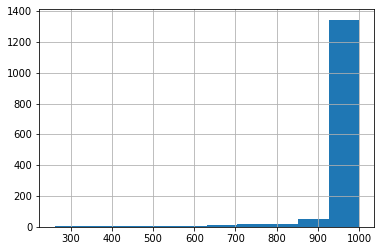

In [144]:
df_gifts2.groupby(['labels', 'group']).Weight.sum().hist()

In [163]:
df_gifts2.head()

,GiftId,Latitude,Longitude,Weight,labels,group,TourId
0,1,16.345769,6.303545,1.000000,12_1,tourVar07,12_1tourVar7
162,163,23.507210,9.083232,5.062926,12_1,tourVar19,12_1tourVar19
178,179,21.528801,8.542897,40.333787,12_1,tourVar15,12_1tourVar15
303,304,23.183570,8.576008,33.139151,12_1,tourVar08,12_1tourVar8
425,426,18.440124,4.358772,8.182597,12_1,tourVar07,12_1tourVar7


In [161]:
df_gifts2.sort_index().to_csv(data_path/'input/gifts2_.csv', encoding='utf-8-sig', index=False)

In [12]:
df_gifts2 = pd.read_csv(data_path/'input/gifts2_.csv')
df_gifts2.shape

(100000, 7)

## traveling salesman

In [36]:
%load_ext autoreload
%autoreload
from tsp_solver import tsp_solver
from path_helper import make_log_path

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
df_gifts2['TourId'] = df_gifts2.labels.astype(str) + df_gifts2.group

In [15]:
df_gifts2.TourId.nunique()

1453

In [16]:
def for_optimize_data(tid):
    label = tid[:-9]
    g_code = tid[-9:]
    data = df_gifts2.query('TourId==@tid')
    data.set_index('GiftId', inplace=True)
    data.loc[0] = [0, 0, 0, label, g_code, tid]
    return data

In [26]:
import warnings
warnings.simplefilter('ignore')
import gc

In [21]:
len(line)

65

In [22]:
len(data)

59

In [23]:
line

[0,
 1344,
 1344,
 1344,
 1344,
 1344,
 1344,
 1344,
 1344,
 1344,
 1344,
 1344,
 1344,
 1344,
 1344,
 1344,
 1344,
 1344,
 1344,
 1344,
 1344,
 1344,
 1344,
 1344,
 1344,
 1344,
 1344,
 1344,
 1344,
 1344,
 1344,
 1344,
 1344,
 1344,
 1344,
 1344,
 1344,
 1344,
 1344,
 1344,
 1344,
 1344,
 1344,
 1344,
 1344,
 1344,
 1344,
 1344,
 1344,
 1344,
 1344,
 1344,
 1344,
 1344,
 1344,
 1344,
 1344,
 1344,
 1344,
 1344,
 1344,
 1344,
 1344,
 1344,
 1344]

In [25]:
data

,Latitude,Longitude,Weight,labels,group,TourId,var_seq
GiftId,,,,,,,
1344,-27.456817,-66.679338,32.456295,0_0,tourVar09,0_0tourVar09,0.0
3462,-12.167212,-59.645977,25.146634,0_0,tourVar09,0_0tourVar09,0.0
4724,-11.011113,-64.432901,24.217076,0_0,tourVar09,0_0tourVar09,0.0
10822,-23.963488,-66.131194,15.312647,0_0,tourVar09,0_0tourVar09,0.0
14162,-19.636382,-59.768684,26.575105,0_0,tourVar09,0_0tourVar09,0.0
15256,-11.860308,-60.965459,4.445284,0_0,tourVar09,0_0tourVar09,0.0
15543,-26.289082,-69.543030,34.343462,0_0,tourVar09,0_0tourVar09,0.0
17639,-10.905950,-63.033319,3.097877,0_0,tourVar09,0_0tourVar09,0.0
21239,-16.882760,-59.621349,38.615011,0_0,tourVar09,0_0tourVar09,0.0


In [24]:
df_val

,1344,3462,4724,10822,14162,15256,15543,17639,21239,23438,24430,30757,32047,34681,34945,36075,38152,40199,41123,43010,45293,45677,45830,46630,47234,47261,50029,50079,51738,53167,53903,54320,57673,57775,59858,61627,63722,64996,67035,68605,70040,70126,71971,72491,73930,74137,74265,77708,78609,82217,83966,84376,85448,87246,89628,90057,92995,97588,0
1344,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3462,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4724,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10822,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14162,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15256,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15543,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17639,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21239,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23438,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
tsp_data_list = []
error_list = []
log_path = make_log_path('TSP')
for i,tid in enumerate(sorted(df_gifts2.TourId.unique())):
    print(f'-------- {i}: {tid} --------')
    df_val, data = tsp_solver(for_optimize_data(tid), log_path)
    tsp_data_list.append(data)
    line = [0]
    try:
        place = 0
        while True:
            place = df_val.loc[place].idxmax()
            if place == 0:
                break
            line.append(place)
            if len(line) > len(data)+5:
                break
    except:
        pass

    if data.sort_values('var_seq').index.values.tolist() == line:
        pass
    else:
        error_list.append(tid)
        print('error: ', tid)
    print('\n\n')
    gc.collect()

出力先：TSP/20200506203703
-------- 0: 0_0tourVar01 --------
データ数:  100
最適化実行中
finish
labels        [0_0, 0]
group      [tourVar01]
データ数               100
max_sec           1800
options     [maxsol 1]
制約付与時間         1.33195
最適化時間          92.2611
status         Optimal
目的関数           28929.3
flg             finish
dtype: object



-------- 1: 0_0tourVar02 --------
データ数:  57
最適化実行中
finish
labels        [0_0, 0]
group      [tourVar02]
データ数                57
max_sec           1800
options     [maxsol 1]
制約付与時間        0.466158
最適化時間          1.47779
status         Optimal
目的関数           33365.1
flg             finish
dtype: object



-------- 2: 0_0tourVar03 --------
データ数:  49
最適化実行中
finish
labels        [0_0, 0]
group      [tourVar03]
データ数                49
max_sec           1800
options     [maxsol 1]
制約付与時間        0.448453
最適化時間         0.802504
status         Optimal
目的関数           49769.2
flg             finish
dtype: object



-------- 3: 0_0tourVar04 --------
データ数:  73
最適化実行中
finish
lab

dtype: object



-------- 27: 0_1tourVar08 --------
データ数:  71
最適化実行中
finish
labels        [0_1, 1]
group      [tourVar08]
データ数                71
max_sec           1800
options     [maxsol 1]
制約付与時間        0.708729
最適化時間          2.17966
status         Optimal
目的関数           35253.1
flg             finish
dtype: object



-------- 28: 0_1tourVar09 --------
データ数:  77
最適化実行中
finish
labels        [0_1, 1]
group      [tourVar09]
データ数                77
max_sec           1800
options     [maxsol 1]
制約付与時間        0.792941
最適化時間          1.96976
status         Optimal
目的関数           56298.5
flg             finish
dtype: object



-------- 29: 0_1tourVar10 --------
データ数:  67
最適化実行中
finish
labels        [0_1, 1]
group      [tourVar10]
データ数                67
max_sec           1800
options     [maxsol 1]
制約付与時間        0.592281
最適化時間          1.16333
status         Optimal
目的関数           33337.7
flg             finish
dtype: object



-------- 30: 0_1tourVar11 --------
データ数:  58
最適化実行中
finish
labels

dtype: object



-------- 54: 10tourVar15 --------
データ数:  69
最適化実行中
finish
labels        [10, 10]
group      [tourVar15]
データ数                69
max_sec           1800
options     [maxsol 1]
制約付与時間        0.602541
最適化時間          1.16682
status         Optimal
目的関数           43940.4
flg             finish
dtype: object



-------- 55: 10tourVar16 --------
データ数:  50
最適化実行中
finish
labels        [10, 10]
group      [tourVar16]
データ数                50
max_sec           1800
options     [maxsol 1]
制約付与時間        0.349327
最適化時間           1.5011
status         Optimal
目的関数           34892.2
flg             finish
dtype: object



-------- 56: 10tourVar17 --------
データ数:  60
最適化実行中
finish
labels        [10, 10]
group      [tourVar17]
データ数                60
max_sec           1800
options     [maxsol 1]
制約付与時間        0.494871
最適化時間         0.901366
status         Optimal
目的関数           48055.7
flg             finish
dtype: object



-------- 57: 10tourVar18 --------
データ数:  100
最適化実行中
finish
labels   

dtype: object



-------- 81: 11_0tourVar18 --------
データ数:  21
最適化実行中
finish
labels     [11_0, 110]
group      [tourVar18]
データ数                21
max_sec           1800
options     [maxsol 1]
制約付与時間        0.134257
最適化時間         0.154907
status         Optimal
目的関数           24477.9
flg             finish
dtype: object



-------- 82: 11_0tourVar19 --------
データ数:  100
最適化実行中
finish
labels     [11_0, 110]
group      [tourVar19]
データ数               100
max_sec           1800
options     [maxsol 1]
制約付与時間         1.35862
最適化時間          88.6831
status         Optimal
目的関数           28807.1
flg             finish
dtype: object



-------- 83: 11_0tourVar21 --------
データ数:  23
最適化実行中
finish
labels     [11_0, 110]
group      [tourVar21]
データ数                23
max_sec           1800
options     [maxsol 1]
制約付与時間        0.106938
最適化時間         0.170034
status         Optimal
目的関数             28140
flg             finish
dtype: object



-------- 84: 11_1tourVar01 --------
データ数:  53
最適化実行中
finish
l

dtype: object



-------- 108: 12_0tourVar11 --------
データ数:  60
最適化実行中
finish
labels     [12_0, 120]
group      [tourVar11]
データ数                60
max_sec           1800
options     [maxsol 1]
制約付与時間         0.46243
最適化時間          14.9221
status         Optimal
目的関数           12383.8
flg             finish
dtype: object



-------- 109: 12_0tourVar12 --------
データ数:  21
最適化実行中
finish
labels     [12_0, 120]
group      [tourVar12]
データ数                21
max_sec           1800
options     [maxsol 1]
制約付与時間       0.0651374
最適化時間         0.124462
status         Optimal
目的関数           12559.8
flg             finish
dtype: object



-------- 110: 12_0tourVar13 --------
データ数:  92
最適化実行中
finish
labels     [12_0, 120]
group      [tourVar13]
データ数                92
max_sec           1800
options     [maxsol 1]
制約付与時間         1.08264
最適化時間          5.03412
status         Optimal
目的関数           21737.4
flg             finish
dtype: object



-------- 111: 12_0tourVar14 --------
データ数:  52
最適化実行中
finis

dtype: object



-------- 135: 13tourVar02 --------
データ数:  72
最適化実行中
finish
labels        [13, 13]
group      [tourVar02]
データ数                72
max_sec           1800
options     [maxsol 1]
制約付与時間        0.658618
最適化時間          1.56909
status         Optimal
目的関数           65425.4
flg             finish
dtype: object



-------- 136: 13tourVar03 --------
データ数:  100
最適化実行中
finish
labels        [13, 13]
group      [tourVar03]
データ数               100
max_sec           1800
options     [maxsol 1]
制約付与時間         1.25919
最適化時間          6.26859
status         Optimal
目的関数           47066.1
flg             finish
dtype: object



-------- 137: 13tourVar04 --------
データ数:  51
最適化実行中
finish
labels        [13, 13]
group      [tourVar04]
データ数                51
max_sec           1800
options     [maxsol 1]
制約付与時間        0.390522
最適化時間         0.666346
status         Optimal
目的関数           37894.1
flg             finish
dtype: object



-------- 138: 13tourVar05 --------
データ数:  101
最適化実行中
finish
labe

dtype: object



-------- 162: 14tourVar12 --------
データ数:  40
最適化実行中
finish
labels        [14, 14]
group      [tourVar12]
データ数                40
max_sec           1800
options     [maxsol 1]
制約付与時間        0.244252
最適化時間         0.331659
status         Optimal
目的関数           47203.3
flg             finish
dtype: object



-------- 163: 14tourVar13 --------
データ数:  67
最適化実行中
finish
labels        [14, 14]
group      [tourVar13]
データ数                67
max_sec           1800
options     [maxsol 1]
制約付与時間        0.609263
最適化時間          1.04244
status         Optimal
目的関数           38017.2
flg             finish
dtype: object



-------- 164: 14tourVar14 --------
データ数:  55
最適化実行中
finish
labels        [14, 14]
group      [tourVar14]
データ数                55
max_sec           1800
options     [maxsol 1]
制約付与時間        0.403773
最適化時間          1.93444
status         Optimal
目的関数           42269.1
flg             finish
dtype: object



-------- 165: 15tourVar01 --------
データ数:  60
最適化実行中
finish
labels

dtype: object



-------- 189: 16tourVar11 --------
データ数:  51
最適化実行中
finish
labels        [16, 16]
group      [tourVar11]
データ数                51
max_sec           1800
options     [maxsol 1]
制約付与時間        0.372804
最適化時間         0.584145
status         Optimal
目的関数           45812.2
flg             finish
dtype: object



-------- 190: 16tourVar12 --------
データ数:  81
最適化実行中
finish
labels        [16, 16]
group      [tourVar12]
データ数                81
max_sec           1800
options     [maxsol 1]
制約付与時間        0.904499
最適化時間          3.32281
status         Optimal
目的関数           44035.1
flg             finish
dtype: object



-------- 191: 16tourVar13 --------
データ数:  56
最適化実行中
finish
labels        [16, 16]
group      [tourVar13]
データ数                56
max_sec           1800
options     [maxsol 1]
制約付与時間        0.460666
最適化時間          1.77389
status         Optimal
目的関数             49105
flg             finish
dtype: object



-------- 192: 16tourVar14 --------
データ数:  60
最適化実行中
finish
labels

dtype: object



-------- 216: 17tourVar13 --------
データ数:  48
最適化実行中
finish
labels        [17, 17]
group      [tourVar13]
データ数                48
max_sec           1800
options     [maxsol 1]
制約付与時間        0.384778
最適化時間           1.3981
status         Optimal
目的関数           38936.7
flg             finish
dtype: object



-------- 217: 17tourVar14 --------
データ数:  60
最適化実行中
finish
labels        [17, 17]
group      [tourVar14]
データ数                60
max_sec           1800
options     [maxsol 1]
制約付与時間         0.49053
最適化時間          1.84072
status         Optimal
目的関数             40932
flg             finish
dtype: object



-------- 218: 17tourVar15 --------
データ数:  69
最適化実行中
finish
labels        [17, 17]
group      [tourVar15]
データ数                69
max_sec           1800
options     [maxsol 1]
制約付与時間        0.665054
最適化時間          1.90555
status         Optimal
目的関数             35076
flg             finish
dtype: object



-------- 219: 17tourVar16 --------
データ数:  101
最適化実行中
finish
label

dtype: object



-------- 243: 18_0tourVar16 --------
データ数:  65
最適化実行中
finish
labels     [18_0, 180]
group      [tourVar16]
データ数                65
max_sec           1800
options     [maxsol 1]
制約付与時間        0.562129
最適化時間          1.88714
status         Optimal
目的関数           76643.6
flg             finish
dtype: object



-------- 244: 18_0tourVar17 --------
データ数:  82
最適化実行中
finish
labels     [18_0, 180]
group      [tourVar17]
データ数                82
max_sec           1800
options     [maxsol 1]
制約付与時間        0.889893
最適化時間          53.8773
status         Optimal
目的関数           36989.9
flg             finish
dtype: object



-------- 245: 18_0tourVar18 --------
データ数:  72
最適化実行中
finish
labels     [18_0, 180]
group      [tourVar18]
データ数                72
max_sec           1800
options     [maxsol 1]
制約付与時間        0.697257
最適化時間          1.68554
status         Optimal
目的関数           71890.4
flg             finish
dtype: object



-------- 246: 18_0tourVar20 --------
データ数:  97
最適化実行中
finis

dtype: object



-------- 270: 19_0tourVar02 --------
データ数:  49
最適化実行中
finish
labels     [19_0, 190]
group      [tourVar02]
データ数                49
max_sec           1800
options     [maxsol 1]
制約付与時間        0.351182
最適化時間          6.10846
status         Optimal
目的関数           18924.1
flg             finish
dtype: object



-------- 271: 19_0tourVar03 --------
データ数:  81
最適化実行中
finish
labels     [19_0, 190]
group      [tourVar03]
データ数                81
max_sec           1800
options     [maxsol 1]
制約付与時間        0.823364
最適化時間          1.47169
status         Optimal
目的関数           29776.4
flg             finish
dtype: object



-------- 272: 19_0tourVar04 --------
データ数:  45
最適化実行中
finish
labels     [19_0, 190]
group      [tourVar04]
データ数                45
max_sec           1800
options     [maxsol 1]
制約付与時間        0.288862
最適化時間          1.20179
status         Optimal
目的関数           19413.1
flg             finish
dtype: object



-------- 273: 19_0tourVar05 --------
データ数:  77
最適化実行中
finis

dtype: object



-------- 297: 19_1tourVar05 --------
データ数:  51
最適化実行中
finish
labels     [19_1, 191]
group      [tourVar05]
データ数                51
max_sec           1800
options     [maxsol 1]
制約付与時間        0.410564
最適化時間          1.28147
status         Optimal
目的関数           27595.1
flg             finish
dtype: object



-------- 298: 19_1tourVar06 --------
データ数:  80
最適化実行中
finish
labels     [19_1, 191]
group      [tourVar06]
データ数                80
max_sec           1800
options     [maxsol 1]
制約付与時間        0.805673
最適化時間           1801.2
status      Not Solved
目的関数           19531.3
flg             finish
dtype: object
error:  19_1tourVar06



-------- 299: 19_1tourVar07 --------
データ数:  92
最適化実行中
finish
labels     [19_1, 191]
group      [tourVar07]
データ数                92
max_sec           1800
options     [maxsol 1]
制約付与時間         1.50995
最適化時間          5.02339
status         Optimal
目的関数           66783.6
flg             finish
dtype: object



-------- 300: 19_1tourVar09 --------


dtype: object



-------- 324: 1_0tourVar12 --------
データ数:  85
最適化実行中
finish
labels       [1_0, 10]
group      [tourVar12]
データ数                85
max_sec           1800
options     [maxsol 1]
制約付与時間        0.950649
最適化時間          3.79436
status         Optimal
目的関数           38681.9
flg             finish
dtype: object



-------- 325: 1_0tourVar14 --------
データ数:  65
最適化実行中
finish
labels       [1_0, 10]
group      [tourVar14]
データ数                65
max_sec           1800
options     [maxsol 1]
制約付与時間         0.56769
最適化時間          1.72265
status         Optimal
目的関数           65054.6
flg             finish
dtype: object



-------- 326: 1_0tourVar15 --------
データ数:  73
最適化実行中
finish
labels       [1_0, 10]
group      [tourVar15]
データ数                73
max_sec           1800
options     [maxsol 1]
制約付与時間        0.701338
最適化時間          2.88988
status         Optimal
目的関数           33878.1
flg             finish
dtype: object



-------- 327: 1_0tourVar16 --------
データ数:  63
最適化実行中
finish
la

dtype: object



-------- 351: 20_0tourVar01 --------
データ数:  99
最適化実行中
finish
labels     [20_0, 200]
group      [tourVar01]
データ数                99
max_sec           1800
options     [maxsol 1]
制約付与時間         1.21456
最適化時間          6.69076
status         Optimal
目的関数           21941.7
flg             finish
dtype: object



-------- 352: 20_0tourVar02 --------
データ数:  99
最適化実行中
finish
labels     [20_0, 200]
group      [tourVar02]
データ数                99
max_sec           1800
options     [maxsol 1]
制約付与時間         1.22632
最適化時間           208.89
status         Optimal
目的関数           30159.7
flg             finish
dtype: object



-------- 353: 20_0tourVar03 --------
データ数:  63
最適化実行中
finish
labels     [20_0, 200]
group      [tourVar03]
データ数                63
max_sec           1800
options     [maxsol 1]
制約付与時間        0.549505
最適化時間          1.45824
status         Optimal
目的関数           53622.7
flg             finish
dtype: object



-------- 354: 20_0tourVar04 --------
データ数:  50
最適化実行中
finis

dtype: object



-------- 378: 20_1tourVar07 --------
データ数:  74
最適化実行中
finish
labels     [20_1, 201]
group      [tourVar07]
データ数                74
max_sec           1800
options     [maxsol 1]
制約付与時間        0.740981
最適化時間          1.50776
status         Optimal
目的関数           23925.6
flg             finish
dtype: object



-------- 379: 20_1tourVar08 --------
データ数:  55
最適化実行中
finish
labels     [20_1, 201]
group      [tourVar08]
データ数                55
max_sec           1800
options     [maxsol 1]
制約付与時間        0.448329
最適化時間          1.36005
status         Optimal
目的関数           23650.3
flg             finish
dtype: object



-------- 380: 20_1tourVar09 --------
データ数:  101
最適化実行中
finish
labels     [20_1, 201]
group      [tourVar09]
データ数               101
max_sec           1800
options     [maxsol 1]
制約付与時間         1.28652
最適化時間          5.59139
status         Optimal
目的関数           33460.6
flg             finish
dtype: object



-------- 381: 20_1tourVar11 --------
データ数:  75
最適化実行中
fini

dtype: object



-------- 405: 21_0tourVar14 --------
データ数:  101
最適化実行中
finish
labels     [21_0, 210]
group      [tourVar14]
データ数               101
max_sec           1800
options     [maxsol 1]
制約付与時間         1.37314
最適化時間          213.711
status         Optimal
目的関数           54973.9
flg             finish
dtype: object



-------- 406: 21_0tourVar15 --------
データ数:  99
最適化実行中
finish
labels     [21_0, 210]
group      [tourVar15]
データ数                99
max_sec           1800
options     [maxsol 1]
制約付与時間         1.25742
最適化時間          7.00696
status         Optimal
目的関数           34730.9
flg             finish
dtype: object



-------- 407: 21_0tourVar17 --------
データ数:  71
最適化実行中
finish
labels     [21_0, 210]
group      [tourVar17]
データ数                71
max_sec           1800
options     [maxsol 1]
制約付与時間        0.683657
最適化時間          2.82991
status         Optimal
目的関数           74675.3
flg             finish
dtype: object



-------- 408: 21_0tourVar18 --------
データ数:  57
最適化実行中
fini

dtype: object



-------- 432: 22tourVar09 --------
データ数:  47
最適化実行中
finish
labels        [22, 22]
group      [tourVar09]
データ数                47
max_sec           1800
options     [maxsol 1]
制約付与時間        0.309574
最適化時間         0.515772
status         Optimal
目的関数             40315
flg             finish
dtype: object



-------- 433: 22tourVar10 --------
データ数:  100
最適化実行中
finish
labels        [22, 22]
group      [tourVar10]
データ数               100
max_sec           1800
options     [maxsol 1]
制約付与時間         1.25357
最適化時間          5.38833
status         Optimal
目的関数           43410.2
flg             finish
dtype: object



-------- 434: 22tourVar11 --------
データ数:  61
最適化実行中
finish
labels        [22, 22]
group      [tourVar11]
データ数                61
max_sec           1800
options     [maxsol 1]
制約付与時間        0.504736
最適化時間          1.25578
status         Optimal
目的関数             66449
flg             finish
dtype: object



-------- 435: 22tourVar12 --------
データ数:  96
最適化実行中
finish
label

dtype: object



-------- 459: 23tourVar19 --------
データ数:  63
最適化実行中
finish
labels        [23, 23]
group      [tourVar19]
データ数                63
max_sec           1800
options     [maxsol 1]
制約付与時間        0.557679
最適化時間         0.891257
status         Optimal
目的関数           58608.2
flg             finish
dtype: object



-------- 460: 23tourVar20 --------
データ数:  51
最適化実行中
finish
labels        [23, 23]
group      [tourVar20]
データ数                51
max_sec           1800
options     [maxsol 1]
制約付与時間        0.357813
最適化時間         0.728084
status         Optimal
目的関数           78476.1
flg             finish
dtype: object



-------- 461: 23tourVar21 --------
データ数:  73
最適化実行中
finish
labels        [23, 23]
group      [tourVar21]
データ数                73
max_sec           1800
options     [maxsol 1]
制約付与時間        0.729388
最適化時間          30.2996
status         Optimal
目的関数           51048.7
flg             finish
dtype: object



-------- 462: 23tourVar22 --------
データ数:  101
最適化実行中
finish
label

dtype: object



-------- 486: 24_1tourVar05 --------
データ数:  96
最適化実行中
finish
labels     [24_1, 241]
group      [tourVar05]
データ数                96
max_sec           1800
options     [maxsol 1]
制約付与時間         1.17973
最適化時間          62.9892
status         Optimal
目的関数           34321.9
flg             finish
dtype: object



-------- 487: 24_1tourVar06 --------
データ数:  96
最適化実行中
finish
labels     [24_1, 241]
group      [tourVar06]
データ数                96
max_sec           1800
options     [maxsol 1]
制約付与時間         1.17036
最適化時間           5.9409
status         Optimal
目的関数           45042.8
flg             finish
dtype: object



-------- 488: 24_1tourVar07 --------
データ数:  56
最適化実行中
finish
labels     [24_1, 241]
group      [tourVar07]
データ数                56
max_sec           1800
options     [maxsol 1]
制約付与時間        0.472861
最適化時間         0.739717
status         Optimal
目的関数           44111.3
flg             finish
dtype: object



-------- 489: 24_1tourVar08 --------
データ数:  59
最適化実行中
finis

dtype: object



-------- 513: 25tourVar14 --------
データ数:  57
最適化実行中
finish
labels        [25, 25]
group      [tourVar14]
データ数                57
max_sec           1800
options     [maxsol 1]
制約付与時間        0.454176
最適化時間          1.10856
status         Optimal
目的関数           61253.3
flg             finish
dtype: object



-------- 514: 25tourVar15 --------
データ数:  30
最適化実行中
finish
labels        [25, 25]
group      [tourVar15]
データ数                30
max_sec           1800
options     [maxsol 1]
制約付与時間         0.19995
最適化時間         0.328491
status         Optimal
目的関数           39988.9
flg             finish
dtype: object



-------- 515: 25tourVar16 --------
データ数:  79
最適化実行中
finish
labels        [25, 25]
group      [tourVar16]
データ数                79
max_sec           1800
options     [maxsol 1]
制約付与時間        0.879752
最適化時間          108.571
status         Optimal
目的関数           38146.1
flg             finish
dtype: object



-------- 516: 25tourVar17 --------
データ数:  100
最適化実行中
finish
label

dtype: object



-------- 540: 26tourVar16 --------
データ数:  54
最適化実行中
finish
labels        [26, 26]
group      [tourVar16]
データ数                54
max_sec           1800
options     [maxsol 1]
制約付与時間        0.398074
最適化時間          1.50874
status         Optimal
目的関数           39950.6
flg             finish
dtype: object



-------- 541: 26tourVar17 --------
データ数:  101
最適化実行中
finish
labels        [26, 26]
group      [tourVar17]
データ数               101
max_sec           1800
options     [maxsol 1]
制約付与時間          1.2796
最適化時間          184.851
status         Optimal
目的関数           66256.3
flg             finish
dtype: object



-------- 542: 26tourVar19 --------
データ数:  100
最適化実行中
finish
labels        [26, 26]
group      [tourVar19]
データ数               100
max_sec           1800
options     [maxsol 1]
制約付与時間         1.27799
最適化時間          86.9464
status         Optimal
目的関数           47585.9
flg             finish
dtype: object



-------- 543: 26tourVar21 --------
データ数:  90
最適化実行中
finish
labe

dtype: object



-------- 565: 27tourVar13 --------
データ数:  65
最適化実行中
finish
labels        [27, 27]
group      [tourVar13]
データ数                65
max_sec           1800
options     [maxsol 1]
制約付与時間        0.827145
最適化時間          3.41801
status         Optimal
目的関数           35864.6
flg             finish
dtype: object



-------- 566: 27tourVar14 --------
データ数:  76
最適化実行中
finish
labels        [27, 27]
group      [tourVar14]
データ数                76
max_sec           1800
options     [maxsol 1]
制約付与時間        0.774049
最適化時間          44.5082
status         Optimal
目的関数           33104.2
flg             finish
dtype: object



-------- 567: 27tourVar15 --------
データ数:  86
最適化実行中
finish
labels        [27, 27]
group      [tourVar15]
データ数                86
max_sec           1800
options     [maxsol 1]
制約付与時間        0.982517
最適化時間          5.01111
status         Optimal
目的関数             51618
flg             finish
dtype: object



-------- 568: 27tourVar16 --------
データ数:  65
最適化実行中
finish
labels

dtype: object



-------- 592: 28tourVar14 --------
データ数:  51
最適化実行中
finish
labels        [28, 28]
group      [tourVar14]
データ数                51
max_sec           1800
options     [maxsol 1]
制約付与時間        0.401767
最適化時間         0.944578
status         Optimal
目的関数           69132.2
flg             finish
dtype: object



-------- 593: 28tourVar15 --------
データ数:  77
最適化実行中
finish
labels        [28, 28]
group      [tourVar15]
データ数                77
max_sec           1800
options     [maxsol 1]
制約付与時間        0.837518
最適化時間          3.05322
status         Optimal
目的関数           53397.9
flg             finish
dtype: object



-------- 594: 28tourVar16 --------
データ数:  97
最適化実行中
finish
labels        [28, 28]
group      [tourVar16]
データ数                97
max_sec           1800
options     [maxsol 1]
制約付与時間         1.27327
最適化時間          56.5955
status         Optimal
目的関数           43532.2
flg             finish
dtype: object



-------- 595: 28tourVar18 --------
データ数:  77
最適化実行中
finish
labels

dtype: object



-------- 619: 2tourVar01 --------
データ数:  62
最適化実行中
finish
labels          [2, 2]
group      [tourVar01]
データ数                62
max_sec           1800
options     [maxsol 1]
制約付与時間        0.571776
最適化時間          1.86641
status         Optimal
目的関数           32188.1
flg             finish
dtype: object



-------- 620: 2tourVar02 --------
データ数:  99
最適化実行中
finish
labels          [2, 2]
group      [tourVar02]
データ数                99
max_sec           1800
options     [maxsol 1]
制約付与時間         1.29798
最適化時間          91.7222
status         Optimal
目的関数           28510.7
flg             finish
dtype: object



-------- 621: 2tourVar03 --------
データ数:  68
最適化実行中
finish
labels          [2, 2]
group      [tourVar03]
データ数                68
max_sec           1800
options     [maxsol 1]
制約付与時間        0.614018
最適化時間          1.40392
status         Optimal
目的関数             81065
flg             finish
dtype: object



-------- 622: 2tourVar04 --------
データ数:  56
最適化実行中
finish
labels    

dtype: object



-------- 646: 2tourVar31 --------
データ数:  79
最適化実行中
finish
labels          [2, 2]
group      [tourVar31]
データ数                79
max_sec           1800
options     [maxsol 1]
制約付与時間        0.805201
最適化時間          3.25224
status         Optimal
目的関数           43287.6
flg             finish
dtype: object



-------- 647: 2tourVar32 --------
データ数:  80
最適化実行中
finish
labels          [2, 2]
group      [tourVar32]
データ数                80
max_sec           1800
options     [maxsol 1]
制約付与時間        0.991999
最適化時間          3.92894
status         Optimal
目的関数           30345.4
flg             finish
dtype: object



-------- 648: 2tourVar33 --------
データ数:  57
最適化実行中
finish
labels          [2, 2]
group      [tourVar33]
データ数                57
max_sec           1800
options     [maxsol 1]
制約付与時間        0.700992
最適化時間          2.11581
status         Optimal
目的関数           43711.8
flg             finish
dtype: object



-------- 649: 30tourVar01 --------
データ数:  50
最適化実行中
finish
labels   

dtype: object
error:  31_0tourVar05



-------- 673: 31_0tourVar06 --------
データ数:  64
最適化実行中
finish
labels     [31_0, 310]
group      [tourVar06]
データ数                64
max_sec           1800
options     [maxsol 1]
制約付与時間        0.557678
最適化時間          2.40198
status         Optimal
目的関数           28015.7
flg             finish
dtype: object



-------- 674: 31_0tourVar07 --------
データ数:  50
最適化実行中
finish
labels     [31_0, 310]
group      [tourVar07]
データ数                50
max_sec           1800
options     [maxsol 1]
制約付与時間        0.360748
最適化時間         0.529804
status         Optimal
目的関数           28491.6
flg             finish
dtype: object



-------- 675: 31_0tourVar08 --------
データ数:  99
最適化実行中
finish
labels     [31_0, 310]
group      [tourVar08]
データ数                99
max_sec           1800
options     [maxsol 1]
制約付与時間         1.30132
最適化時間          78.7526
status         Optimal
目的関数           29761.5
flg             finish
dtype: object



-------- 676: 31_0tourVar09 --------


dtype: object



-------- 700: 31_1tourVar14 --------
データ数:  65
最適化実行中
finish
labels     [31_1, 311]
group      [tourVar14]
データ数                65
max_sec           1800
options     [maxsol 1]
制約付与時間        0.558158
最適化時間          18.6916
status         Optimal
目的関数           29618.7
flg             finish
dtype: object



-------- 701: 31_1tourVar15 --------
データ数:  90
最適化実行中
finish
labels     [31_1, 311]
group      [tourVar15]
データ数                90
max_sec           1800
options     [maxsol 1]
制約付与時間         1.13435
最適化時間          4.41799
status         Optimal
目的関数           38846.7
flg             finish
dtype: object



-------- 702: 31_1tourVar16 --------
データ数:  91
最適化実行中
finish
labels     [31_1, 311]
group      [tourVar16]
データ数                91
max_sec           1800
options     [maxsol 1]
制約付与時間         1.09176
最適化時間          4.60906
status         Optimal
目的関数           46016.6
flg             finish
dtype: object



-------- 703: 31_1tourVar17 --------
データ数:  25
最適化実行中
finis

dtype: object



-------- 727: 33tourVar02 --------
データ数:  71
最適化実行中
finish
labels        [33, 33]
group      [tourVar02]
データ数                71
max_sec           1800
options     [maxsol 1]
制約付与時間        0.655306
最適化時間          24.5801
status         Optimal
目的関数           29462.5
flg             finish
dtype: object



-------- 728: 33tourVar03 --------
データ数:  100
最適化実行中
finish
labels        [33, 33]
group      [tourVar03]
データ数               100
max_sec           1800
options     [maxsol 1]
制約付与時間         1.29675
最適化時間          7.48858
status         Optimal
目的関数           36889.9
flg             finish
dtype: object



-------- 729: 33tourVar05 --------
データ数:  99
最適化実行中
finish
labels        [33, 33]
group      [tourVar05]
データ数                99
max_sec           1800
options     [maxsol 1]
制約付与時間         1.33415
最適化時間          100.056
status         Optimal
目的関数           31706.3
flg             finish
dtype: object



-------- 730: 33tourVar06 --------
データ数:  53
最適化実行中
finish
label

dtype: object



-------- 754: 34_0tourVar13 --------
データ数:  87
最適化実行中
finish
labels     [34_0, 340]
group      [tourVar13]
データ数                87
max_sec           1800
options     [maxsol 1]
制約付与時間         1.05165
最適化時間          52.5813
status         Optimal
目的関数           14011.3
flg             finish
dtype: object



-------- 755: 34_0tourVar14 --------
データ数:  34
最適化実行中
finish
labels     [34_0, 340]
group      [tourVar14]
データ数                34
max_sec           1800
options     [maxsol 1]
制約付与時間        0.193728
最適化時間         0.325467
status         Optimal
目的関数           13387.6
flg             finish
dtype: object



-------- 756: 34_0tourVar16 --------
データ数:  100
最適化実行中
finish
labels     [34_0, 340]
group      [tourVar16]
データ数               100
max_sec           1800
options     [maxsol 1]
制約付与時間         1.46506
最適化時間          7.43734
status         Optimal
目的関数             27671
flg             finish
dtype: object



-------- 757: 34_0tourVar17 --------
データ数:  82
最適化実行中
fini

dtype: object



-------- 781: 35_0tourVar02 --------
データ数:  49
最適化実行中
finish
labels     [35_0, 350]
group      [tourVar02]
データ数                49
max_sec           1800
options     [maxsol 1]
制約付与時間         0.32332
最適化時間         0.854738
status         Optimal
目的関数           44866.3
flg             finish
dtype: object



-------- 782: 35_0tourVar03 --------
データ数:  61
最適化実行中
finish
labels     [35_0, 350]
group      [tourVar03]
データ数                61
max_sec           1800
options     [maxsol 1]
制約付与時間        0.487412
最適化時間          1.21523
status         Optimal
目的関数           41146.3
flg             finish
dtype: object



-------- 783: 35_0tourVar04 --------
データ数:  72
最適化実行中
finish
labels     [35_0, 350]
group      [tourVar04]
データ数                72
max_sec           1800
options     [maxsol 1]
制約付与時間        0.705199
最適化時間          24.7015
status         Optimal
目的関数           20682.7
flg             finish
dtype: object



-------- 784: 35_0tourVar05 --------
データ数:  101
最適化実行中
fini

dtype: object



-------- 808: 35_1tourVar12 --------
データ数:  59
最適化実行中
finish
labels     [35_1, 351]
group      [tourVar12]
データ数                59
max_sec           1800
options     [maxsol 1]
制約付与時間        0.484747
最適化時間         0.684615
status         Optimal
目的関数           22730.6
flg             finish
dtype: object



-------- 809: 35_1tourVar13 --------
データ数:  67
最適化実行中
finish
labels     [35_1, 351]
group      [tourVar13]
データ数                67
max_sec           1800
options     [maxsol 1]
制約付与時間        0.609613
最適化時間           2.5737
status         Optimal
目的関数           23646.2
flg             finish
dtype: object



-------- 810: 35_1tourVar14 --------
データ数:  42
最適化実行中
finish
labels     [35_1, 351]
group      [tourVar14]
データ数                42
max_sec           1800
options     [maxsol 1]
制約付与時間        0.255332
最適化時間         0.601225
status         Optimal
目的関数           36192.2
flg             finish
dtype: object



-------- 811: 35_1tourVar15 --------
データ数:  75
最適化実行中
finis

dtype: object



-------- 835: 36_0tourVar16 --------
データ数:  101
最適化実行中
finish
labels     [36_0, 360]
group      [tourVar16]
データ数               101
max_sec           1800
options     [maxsol 1]
制約付与時間          1.3339
最適化時間          1801.45
status      Not Solved
目的関数           30800.2
flg             finish
dtype: object
error:  36_0tourVar16



-------- 836: 36_0tourVar18 --------
データ数:  101
最適化実行中
finish
labels     [36_0, 360]
group      [tourVar18]
データ数               101
max_sec           1800
options     [maxsol 1]
制約付与時間         1.35424
最適化時間          59.3405
status         Optimal
目的関数           35346.3
flg             finish
dtype: object



-------- 837: 36_0tourVar19 --------
データ数:  33
最適化実行中
finish
labels     [36_0, 360]
group      [tourVar19]
データ数                33
max_sec           1800
options     [maxsol 1]
制約付与時間        0.237862
最適化時間         0.376398
status         Optimal
目的関数           48049.9
flg             finish
dtype: object



-------- 838: 36_0tourVar20 -------

dtype: object



-------- 862: 37_0tourVar10 --------
データ数:  54
最適化実行中
finish
labels     [37_0, 370]
group      [tourVar10]
データ数                54
max_sec           1800
options     [maxsol 1]
制約付与時間        0.420038
最適化時間          1.73165
status         Optimal
目的関数             29691
flg             finish
dtype: object



-------- 863: 37_0tourVar11 --------
データ数:  98
最適化実行中
finish
labels     [37_0, 370]
group      [tourVar11]
データ数                98
max_sec           1800
options     [maxsol 1]
制約付与時間         1.23018
最適化時間          5.48697
status         Optimal
目的関数           45218.9
flg             finish
dtype: object



-------- 864: 37_0tourVar12 --------
データ数:  59
最適化実行中
finish
labels     [37_0, 370]
group      [tourVar12]
データ数                59
max_sec           1800
options     [maxsol 1]
制約付与時間        0.617951
最適化時間          1.79864
status         Optimal
目的関数           38270.5
flg             finish
dtype: object



-------- 865: 37_0tourVar13 --------
データ数:  59
最適化実行中
finis

dtype: object



-------- 889: 37_1tourVar17 --------
データ数:  101
最適化実行中
finish
labels     [37_1, 371]
group      [tourVar17]
データ数               101
max_sec           1800
options     [maxsol 1]
制約付与時間         1.54655
最適化時間          92.4328
status         Optimal
目的関数           34145.2
flg             finish
dtype: object



-------- 890: 37_1tourVar18 --------
データ数:  73
最適化実行中
finish
labels     [37_1, 371]
group      [tourVar18]
データ数                73
max_sec           1800
options     [maxsol 1]
制約付与時間        0.993099
最適化時間          2.10194
status         Optimal
目的関数           65267.7
flg             finish
dtype: object



-------- 891: 37_1tourVar20 --------
データ数:  27
最適化実行中
finish
labels     [37_1, 371]
group      [tourVar20]
データ数                27
max_sec           1800
options     [maxsol 1]
制約付与時間        0.130923
最適化時間         0.282377
status         Optimal
目的関数           36730.6
flg             finish
dtype: object



-------- 892: 37_1tourVar21 --------
データ数:  100
最適化実行中
fin

dtype: object



-------- 916: 38_1tourVar04 --------
データ数:  101
最適化実行中
finish
labels     [38_1, 381]
group      [tourVar04]
データ数               101
max_sec           1800
options     [maxsol 1]
制約付与時間          1.2537
最適化時間          210.125
status         Optimal
目的関数           45568.4
flg             finish
dtype: object



-------- 917: 38_1tourVar05 --------
データ数:  56
最適化実行中
finish
labels     [38_1, 381]
group      [tourVar05]
データ数                56
max_sec           1800
options     [maxsol 1]
制約付与時間        0.415279
最適化時間          1.88574
status         Optimal
目的関数           26087.9
flg             finish
dtype: object



-------- 918: 38_1tourVar06 --------
データ数:  99
最適化実行中
finish
labels     [38_1, 381]
group      [tourVar06]
データ数                99
max_sec           1800
options     [maxsol 1]
制約付与時間         1.24885
最適化時間          81.0702
status         Optimal
目的関数           28642.7
flg             finish
dtype: object



-------- 919: 38_1tourVar07 --------
データ数:  29
最適化実行中
fini

dtype: object



-------- 943: 39tourVar14 --------
データ数:  101
最適化実行中
finish
labels        [39, 39]
group      [tourVar14]
データ数               101
max_sec           1800
options     [maxsol 1]
制約付与時間         1.31445
最適化時間          6.02333
status         Optimal
目的関数           56429.7
flg             finish
dtype: object



-------- 944: 39tourVar15 --------
データ数:  76
最適化実行中
finish
labels        [39, 39]
group      [tourVar15]
データ数                76
max_sec           1800
options     [maxsol 1]
制約付与時間        0.781524
最適化時間          3.67667
status         Optimal
目的関数           74064.2
flg             finish
dtype: object



-------- 945: 39tourVar16 --------
データ数:  60
最適化実行中
finish
labels        [39, 39]
group      [tourVar16]
データ数                60
max_sec           1800
options     [maxsol 1]
制約付与時間        0.506285
最適化時間           2.1177
status         Optimal
目的関数           54154.6
flg             finish
dtype: object



-------- 946: 39tourVar17 --------
データ数:  64
最適化実行中
finish
label

dtype: object



-------- 970: 3_1tourVar01 --------
データ数:  101
最適化実行中
finish
labels       [3_1, 31]
group      [tourVar01]
データ数               101
max_sec           1800
options     [maxsol 1]
制約付与時間         1.32099
最適化時間          1801.23
status      Not Solved
目的関数             34077
flg             finish
dtype: object
error:  3_1tourVar01



-------- 971: 3_1tourVar02 --------
データ数:  98
最適化実行中
finish
labels       [3_1, 31]
group      [tourVar02]
データ数                98
max_sec           1800
options     [maxsol 1]
制約付与時間         1.30143
最適化時間          67.4333
status         Optimal
目的関数           36239.4
flg             finish
dtype: object



-------- 972: 3_1tourVar03 --------
データ数:  61
最適化実行中
finish
labels       [3_1, 31]
group      [tourVar03]
データ数                61
max_sec           1800
options     [maxsol 1]
制約付与時間        0.469926
最適化時間          2.28224
status         Optimal
目的関数           37375.6
flg             finish
dtype: object



-------- 973: 3_1tourVar04 --------
データ数

dtype: object



-------- 997: 40_0tourVar15 --------
データ数:  92
最適化実行中
finish
labels     [40_0, 400]
group      [tourVar15]
データ数                92
max_sec           1800
options     [maxsol 1]
制約付与時間         1.19415
最適化時間           43.341
status         Optimal
目的関数           35709.5
flg             finish
dtype: object



-------- 998: 40_0tourVar16 --------
データ数:  97
最適化実行中
finish
labels     [40_0, 400]
group      [tourVar16]
データ数                97
max_sec           1800
options     [maxsol 1]
制約付与時間         1.21732
最適化時間          198.628
status         Optimal
目的関数           55549.3
flg             finish
dtype: object



-------- 999: 40_0tourVar17 --------
データ数:  91
最適化実行中
finish
labels     [40_0, 400]
group      [tourVar17]
データ数                91
max_sec           1800
options     [maxsol 1]
制約付与時間         1.16272
最適化時間          3.76958
status         Optimal
目的関数           40083.1
flg             finish
dtype: object



-------- 1000: 40_0tourVar18 --------
データ数:  49
最適化実行中
fini

dtype: object



-------- 1024: 41tourVar03 --------
データ数:  93
最適化実行中
finish
labels        [41, 41]
group      [tourVar03]
データ数                93
max_sec           1800
options     [maxsol 1]
制約付与時間         2.64015
最適化時間          54.4388
status         Optimal
目的関数           31710.7
flg             finish
dtype: object



-------- 1025: 41tourVar04 --------
データ数:  85
最適化実行中
finish
labels        [41, 41]
group      [tourVar04]
データ数                85
max_sec           1800
options     [maxsol 1]
制約付与時間         1.34666
最適化時間          42.0917
status         Optimal
目的関数           32678.7
flg             finish
dtype: object



-------- 1026: 41tourVar05 --------
データ数:  45
最適化実行中
finish
labels        [41, 41]
group      [tourVar05]
データ数                45
max_sec           1800
options     [maxsol 1]
制約付与時間        0.363497
最適化時間         0.988094
status         Optimal
目的関数           56269.2
flg             finish
dtype: object



-------- 1027: 41tourVar06 --------
データ数:  74
最適化実行中
finish
la

dtype: object



-------- 1051: 42tourVar10 --------
データ数:  21
最適化実行中
finish
labels        [42, 42]
group      [tourVar10]
データ数                21
max_sec           1800
options     [maxsol 1]
制約付与時間       0.0749555
最適化時間         0.138202
status         Optimal
目的関数           30652.8
flg             finish
dtype: object



-------- 1052: 42tourVar11 --------
データ数:  59
最適化実行中
finish
labels        [42, 42]
group      [tourVar11]
データ数                59
max_sec           1800
options     [maxsol 1]
制約付与時間        0.472961
最適化時間          2.33536
status         Optimal
目的関数           40791.6
flg             finish
dtype: object



-------- 1053: 42tourVar12 --------
データ数:  43
最適化実行中
finish
labels        [42, 42]
group      [tourVar12]
データ数                43
max_sec           1800
options     [maxsol 1]
制約付与時間        0.260166
最適化時間         0.825265
status         Optimal
目的関数           59568.1
flg             finish
dtype: object



-------- 1054: 42tourVar13 --------
データ数:  98
最適化実行中
finish
la

dtype: object



-------- 1078: 43tourVar08 --------
データ数:  50
最適化実行中
finish
labels        [43, 43]
group      [tourVar08]
データ数                50
max_sec           1800
options     [maxsol 1]
制約付与時間        0.368788
最適化時間          1.33611
status         Optimal
目的関数           33485.8
flg             finish
dtype: object



-------- 1079: 43tourVar09 --------
データ数:  63
最適化実行中
finish
labels        [43, 43]
group      [tourVar09]
データ数                63
max_sec           1800
options     [maxsol 1]
制約付与時間        0.541689
最適化時間          2.29535
status         Optimal
目的関数           32567.8
flg             finish
dtype: object



-------- 1080: 43tourVar10 --------
データ数:  65
最適化実行中
finish
labels        [43, 43]
group      [tourVar10]
データ数                65
max_sec           1800
options     [maxsol 1]
制約付与時間        0.602836
最適化時間          2.20906
status         Optimal
目的関数           38899.3
flg             finish
dtype: object



-------- 1081: 43tourVar11 --------
データ数:  55
最適化実行中
finish
la

dtype: object
error:  44tourVar21



-------- 1105: 44tourVar22 --------
データ数:  73
最適化実行中
finish
labels        [44, 44]
group      [tourVar22]
データ数                73
max_sec           1800
options     [maxsol 1]
制約付与時間        0.853549
最適化時間           22.318
status         Optimal
目的関数           47313.4
flg             finish
dtype: object



-------- 1106: 44tourVar23 --------
データ数:  39
最適化実行中
finish
labels        [44, 44]
group      [tourVar23]
データ数                39
max_sec           1800
options     [maxsol 1]
制約付与時間        0.283838
最適化時間         0.706904
status         Optimal
目的関数           76914.8
flg             finish
dtype: object



-------- 1107: 44tourVar25 --------
データ数:  71
最適化実行中
finish
labels        [44, 44]
group      [tourVar25]
データ数                71
max_sec           1800
options     [maxsol 1]
制約付与時間        0.969691
最適化時間          2.24491
status         Optimal
目的関数            135506
flg             finish
dtype: object



-------- 1108: 44tourVar26 --------
データ数: 

dtype: object



-------- 1130: 45_0tourVar20 --------
データ数:  68
最適化実行中
finish
labels     [45_0, 450]
group      [tourVar20]
データ数                68
max_sec           1800
options     [maxsol 1]
制約付与時間        0.582759
最適化時間          2.51043
status         Optimal
目的関数           34834.8
flg             finish
dtype: object



-------- 1131: 45_0tourVar21 --------
データ数:  24
最適化実行中
finish
labels     [45_0, 450]
group      [tourVar21]
データ数                24
max_sec           1800
options     [maxsol 1]
制約付与時間         0.11693
最適化時間         0.238862
status         Optimal
目的関数           31664.9
flg             finish
dtype: object



-------- 1132: 45_0tourVar22 --------
データ数:  88
最適化実行中
finish
labels     [45_0, 450]
group      [tourVar22]
データ数                88
max_sec           1800
options     [maxsol 1]
制約付与時間         1.02227
最適化時間          115.815
status         Optimal
目的関数           36616.8
flg             finish
dtype: object



-------- 1133: 45_0tourVar23 --------
データ数:  49
最適化実行中
f

dtype: object



-------- 1157: 45_1tourVar17 --------
データ数:  82
最適化実行中
finish
labels     [45_1, 451]
group      [tourVar17]
データ数                82
max_sec           1800
options     [maxsol 1]
制約付与時間         0.83437
最適化時間          3.31302
status         Optimal
目的関数           36736.5
flg             finish
dtype: object



-------- 1158: 45_1tourVar18 --------
データ数:  80
最適化実行中
finish
labels     [45_1, 451]
group      [tourVar18]
データ数                80
max_sec           1800
options     [maxsol 1]
制約付与時間        0.844293
最適化時間          1.86844
status         Optimal
目的関数           70144.6
flg             finish
dtype: object



-------- 1159: 45_1tourVar19 --------
データ数:  53
最適化実行中
finish
labels     [45_1, 451]
group      [tourVar19]
データ数                53
max_sec           1800
options     [maxsol 1]
制約付与時間        0.367726
最適化時間          12.4328
status         Optimal
目的関数           33614.7
flg             finish
dtype: object



-------- 1160: 45_1tourVar20 --------
データ数:  74
最適化実行中
f

dtype: object



-------- 1184: 46_0tourVar19 --------
データ数:  66
最適化実行中
finish
labels     [46_0, 460]
group      [tourVar19]
データ数                66
max_sec           1800
options     [maxsol 1]
制約付与時間        0.880386
最適化時間          21.3012
status         Optimal
目的関数           14753.5
flg             finish
dtype: object



-------- 1185: 46_1tourVar01 --------
データ数:  50
最適化実行中
finish
labels     [46_1, 461]
group      [tourVar01]
データ数                50
max_sec           1800
options     [maxsol 1]
制約付与時間        0.357612
最適化時間         0.961882
status         Optimal
目的関数             44241
flg             finish
dtype: object



-------- 1186: 46_1tourVar02 --------
データ数:  45
最適化実行中
finish
labels     [46_1, 461]
group      [tourVar02]
データ数                45
max_sec           1800
options     [maxsol 1]
制約付与時間        0.270349
最適化時間         0.863669
status         Optimal
目的関数           23516.2
flg             finish
dtype: object



-------- 1187: 46_1tourVar03 --------
データ数:  73
最適化実行中
f

dtype: object



-------- 1211: 47_0tourVar08 --------
データ数:  83
最適化実行中
finish
labels     [47_0, 470]
group      [tourVar08]
データ数                83
max_sec           1800
options     [maxsol 1]
制約付与時間        0.953428
最適化時間           131.16
status         Optimal
目的関数           38644.2
flg             finish
dtype: object



-------- 1212: 47_0tourVar09 --------
データ数:  100
最適化実行中
finish
labels     [47_0, 470]
group      [tourVar09]
データ数               100
max_sec           1800
options     [maxsol 1]
制約付与時間           1.386
最適化時間          84.3355
status         Optimal
目的関数           24548.4
flg             finish
dtype: object



-------- 1213: 47_0tourVar10 --------
データ数:  63
最適化実行中
finish
labels     [47_0, 470]
group      [tourVar10]
データ数                63
max_sec           1800
options     [maxsol 1]
制約付与時間        0.514406
最適化時間          2.59129
status         Optimal
目的関数           30425.4
flg             finish
dtype: object



-------- 1214: 47_0tourVar11 --------
データ数:  40
最適化実行中


dtype: object



-------- 1238: 47_1tourVar20 --------
データ数:  85
最適化実行中
finish
labels     [47_1, 471]
group      [tourVar20]
データ数                85
max_sec           1800
options     [maxsol 1]
制約付与時間        0.980253
最適化時間          86.2612
status         Optimal
目的関数           19286.3
flg             finish
dtype: object



-------- 1239: 48tourVar01 --------
データ数:  53
最適化実行中
finish
labels        [48, 48]
group      [tourVar01]
データ数                53
max_sec           1800
options     [maxsol 1]
制約付与時間        0.413761
最適化時間          1.43343
status         Optimal
目的関数           34178.7
flg             finish
dtype: object



-------- 1240: 48tourVar02 --------
データ数:  53
最適化実行中
finish
labels        [48, 48]
group      [tourVar02]
データ数                53
max_sec           1800
options     [maxsol 1]
制約付与時間        0.400768
最適化時間          10.6431
status         Optimal
目的関数           34399.6
flg             finish
dtype: object



-------- 1241: 48tourVar03 --------
データ数:  59
最適化実行中
finish


dtype: object



-------- 1265: 49_0tourVar13 --------
データ数:  48
最適化実行中
finish
labels     [49_0, 490]
group      [tourVar13]
データ数                48
max_sec           1800
options     [maxsol 1]
制約付与時間        0.337824
最適化時間          1.46058
status         Optimal
目的関数           24113.1
flg             finish
dtype: object



-------- 1266: 49_0tourVar14 --------
データ数:  86
最適化実行中
finish
labels     [49_0, 490]
group      [tourVar14]
データ数                86
max_sec           1800
options     [maxsol 1]
制約付与時間         1.02659
最適化時間          47.4598
status         Optimal
目的関数           22092.7
flg             finish
dtype: object



-------- 1267: 49_0tourVar15 --------
データ数:  58
最適化実行中
finish
labels     [49_0, 490]
group      [tourVar15]
データ数                58
max_sec           1800
options     [maxsol 1]
制約付与時間        0.466733
最適化時間          1.46439
status         Optimal
目的関数           16855.3
flg             finish
dtype: object



-------- 1268: 49_0tourVar16 --------
データ数:  50
最適化実行中
f

dtype: object



-------- 1292: 49_1tourVar16 --------
データ数:  56
最適化実行中
finish
labels     [49_1, 491]
group      [tourVar16]
データ数                56
max_sec           1800
options     [maxsol 1]
制約付与時間        0.435181
最適化時間         0.894518
status         Optimal
目的関数           39917.8
flg             finish
dtype: object



-------- 1293: 49_1tourVar17 --------
データ数:  53
最適化実行中
finish
labels     [49_1, 491]
group      [tourVar17]
データ数                53
max_sec           1800
options     [maxsol 1]
制約付与時間         0.41478
最適化時間          1.41041
status         Optimal
目的関数           20328.4
flg             finish
dtype: object



-------- 1294: 49_1tourVar18 --------
データ数:  81
最適化実行中
finish
labels     [49_1, 491]
group      [tourVar18]
データ数                81
max_sec           1800
options     [maxsol 1]
制約付与時間        0.864967
最適化時間          3.18189
status         Optimal
目的関数           24253.1
flg             finish
dtype: object



-------- 1295: 4tourVar01 --------
データ数:  94
最適化実行中
fini

dtype: object



-------- 1317: 4tourVar24 --------
データ数:  24
最適化実行中
finish
labels          [4, 4]
group      [tourVar24]
データ数                24
max_sec           1800
options     [maxsol 1]
制約付与時間       0.0781233
最適化時間         0.218561
status         Optimal
目的関数           48394.9
flg             finish
dtype: object



-------- 1318: 4tourVar25 --------
データ数:  99
最適化実行中
finish
labels          [4, 4]
group      [tourVar25]
データ数                99
max_sec           1800
options     [maxsol 1]
制約付与時間           1.742
最適化時間          7.70005
status         Optimal
目的関数           50059.6
flg             finish
dtype: object



-------- 1319: 4tourVar27 --------
データ数:  62
最適化実行中
finish
labels          [4, 4]
group      [tourVar27]
データ数                62
max_sec           1800
options     [maxsol 1]
制約付与時間        0.827232
最適化時間          7.30908
status         Optimal
目的関数             48364
flg             finish
dtype: object



-------- 1320: 4tourVar28 --------
データ数:  72
最適化実行中
finish
labels

dtype: object



-------- 1344: 5tourVar22 --------
データ数:  101
最適化実行中
finish
labels          [5, 5]
group      [tourVar22]
データ数               101
max_sec           1800
options     [maxsol 1]
制約付与時間         1.32542
最適化時間          76.8608
status         Optimal
目的関数           27732.5
flg             finish
dtype: object



-------- 1345: 5tourVar23 --------
データ数:  71
最適化実行中
finish
labels          [5, 5]
group      [tourVar23]
データ数                71
max_sec           1800
options     [maxsol 1]
制約付与時間        0.869519
最適化時間           2.9523
status         Optimal
目的関数           35939.4
flg             finish
dtype: object



-------- 1346: 5tourVar24 --------
データ数:  78
最適化実行中
finish
labels          [5, 5]
group      [tourVar24]
データ数                78
max_sec           1800
options     [maxsol 1]
制約付与時間        0.854525
最適化時間          4.28724
status         Optimal
目的関数             30283
flg             finish
dtype: object



-------- 1347: 5tourVar26 --------
データ数:  96
最適化実行中
finish
label

dtype: object



-------- 1369: 6tourVar18 --------
データ数:  78
最適化実行中
finish
labels          [6, 6]
group      [tourVar18]
データ数                78
max_sec           1800
options     [maxsol 1]
制約付与時間        0.939255
最適化時間          5.89379
status         Optimal
目的関数           40271.6
flg             finish
dtype: object



-------- 1370: 6tourVar20 --------
データ数:  68
最適化実行中
finish
labels          [6, 6]
group      [tourVar20]
データ数                68
max_sec           1800
options     [maxsol 1]
制約付与時間        0.694913
最適化時間          3.13125
status         Optimal
目的関数           76504.1
flg             finish
dtype: object



-------- 1371: 6tourVar21 --------
データ数:  60
最適化実行中
finish
labels          [6, 6]
group      [tourVar21]
データ数                60
max_sec           1800
options     [maxsol 1]
制約付与時間        0.527543
最適化時間          2.34869
status         Optimal
目的関数             41446
flg             finish
dtype: object



-------- 1372: 6tourVar22 --------
データ数:  87
最適化実行中
finish
labels

dtype: object



-------- 1396: 8tourVar02 --------
データ数:  58
最適化実行中
finish
labels          [8, 8]
group      [tourVar02]
データ数                58
max_sec           1800
options     [maxsol 1]
制約付与時間        0.463758
最適化時間          1.57817
status         Optimal
目的関数           30336.3
flg             finish
dtype: object



-------- 1397: 8tourVar03 --------
データ数:  55
最適化実行中
finish
labels          [8, 8]
group      [tourVar03]
データ数                55
max_sec           1800
options     [maxsol 1]
制約付与時間        0.421325
最適化時間         0.880455
status         Optimal
目的関数           53339.1
flg             finish
dtype: object



-------- 1398: 8tourVar04 --------
データ数:  58
最適化実行中
finish
labels          [8, 8]
group      [tourVar04]
データ数                58
max_sec           1800
options     [maxsol 1]
制約付与時間        0.472474
最適化時間          1.21485
status         Optimal
目的関数           57199.4
flg             finish
dtype: object



-------- 1399: 8tourVar05 --------
データ数:  99
最適化実行中
finish
labels

dtype: object



-------- 1423: 9_0tourVar12 --------
データ数:  58
最適化実行中
finish
labels       [9_0, 90]
group      [tourVar12]
データ数                58
max_sec           1800
options     [maxsol 1]
制約付与時間        0.467367
最適化時間         0.831449
status         Optimal
目的関数           42472.3
flg             finish
dtype: object



-------- 1424: 9_0tourVar13 --------
データ数:  56
最適化実行中
finish
labels       [9_0, 90]
group      [tourVar13]
データ数                56
max_sec           1800
options     [maxsol 1]
制約付与時間        0.418778
最適化時間         0.915561
status         Optimal
目的関数           58798.3
flg             finish
dtype: object



-------- 1425: 9_0tourVar14 --------
データ数:  49
最適化実行中
finish
labels       [9_0, 90]
group      [tourVar14]
データ数                49
max_sec           1800
options     [maxsol 1]
制約付与時間         0.34682
最適化時間         0.557698
status         Optimal
目的関数           35771.8
flg             finish
dtype: object



-------- 1426: 9_0tourVar15 --------
データ数:  99
最適化実行中
finis

dtype: object



-------- 1450: 9_1tourVar19 --------
データ数:  63
最適化実行中
finish
labels       [9_1, 91]
group      [tourVar19]
データ数                63
max_sec           1800
options     [maxsol 1]
制約付与時間        0.547281
最適化時間          1.93659
status         Optimal
目的関数             37229
flg             finish
dtype: object



-------- 1451: 9_1tourVar21 --------
データ数:  101
最適化実行中
finish
labels       [9_1, 91]
group      [tourVar21]
データ数               101
max_sec           1800
options     [maxsol 1]
制約付与時間         1.60083
最適化時間          6.99064
status         Optimal
目的関数           42727.2
flg             finish
dtype: object



-------- 1452: 9_1tourVar22 --------
データ数:  101
最適化実行中
finish
labels       [9_1, 91]
group      [tourVar22]
データ数               101
max_sec           1800
options     [maxsol 1]
制約付与時間         1.63288
最適化時間          385.673
status         Optimal
目的関数           58500.5
flg             finish
dtype: object





In [40]:
pd.Series(error_list).to_csv('error_list.csv', encoding='utf-8-sig', index=False)

In [53]:
error_list

['0_0tourVar18',
 '0_1tourVar02',
 '11_1tourVar06',
 '13tourVar20',
 '16tourVar21',
 '19_1tourVar06',
 '19_1tourVar22',
 '1_0tourVar02',
 '21_0tourVar01',
 '24_0tourVar11',
 '24_0tourVar20',
 '26tourVar05',
 '26tourVar28',
 '27tourVar10',
 '2tourVar14',
 '30tourVar07',
 '31_0tourVar05',
 '32tourVar05',
 '32tourVar06',
 '34_1tourVar17',
 '36_0tourVar16',
 '38_0tourVar02',
 '3_1tourVar01',
 '44tourVar20',
 '44tourVar21',
 '44tourVar27',
 '47_1tourVar04',
 '48tourVar06',
 '4tourVar07',
 '4tourVar11',
 '5tourVar16',
 '5tourVar26',
 '5tourVar32',
 '6tourVar01']

In [63]:
success_data_list = []
error_data_list = []

for tmp in tsp_data_list:
    tid = tmp.TourId.unique()[0]
    if tid not in error_list:
        success_list.append(tmp)
    else:
        error_data_list.append(tmp)

In [56]:
len(success_list) + len(error_list)

1453

In [59]:
len(error_list)

34

In [60]:
df_gifts3 = pd.concat(success_data_list)

In [65]:
df_gifts3.to_csv('df_gifts3.csv', encoding='utf-8-sig')

In [66]:
for data in error_data_list:
    data.rename(columns={'var_seq': 'var_seq2'}, inplace=True)
    data.sort_index(inplace=True)
    data['var_seq'] = list(range(len(data)))

In [67]:
error_data_list[0]

,Latitude,Longitude,Weight,labels,group,TourId,var_seq2,var_seq
GiftId,,,,,,,,
0,0.000000,0.000000,0.000000,0_0,tourVar18,0_0tourVar18,0.000000,0
2892,-20.873378,-68.767459,14.789573,0_0,tourVar18,0_0tourVar18,2.666667,1
4930,-9.792708,-62.316706,15.229436,0_0,tourVar18,0_0tourVar18,2.500000,2
5558,-24.836759,-68.326001,10.995348,0_0,tourVar18,0_0tourVar18,2.666667,3
5795,-13.304368,-62.621364,5.785660,0_0,tourVar18,0_0tourVar18,2.000000,4
...,...,...,...,...,...,...,...,...
90904,-16.243102,-57.511624,16.655327,0_0,tourVar18,0_0tourVar18,2.047120,92
91197,-23.726767,-69.947846,20.816492,0_0,tourVar18,0_0tourVar18,2.000000,93
91918,-17.466502,-70.045883,2.247262,0_0,tourVar18,0_0tourVar18,14.549738,94


In [69]:
pd.concat(error_data_list).to_csv('error_data_list.csv', encoding='utf-8-sig')

In [70]:
df_errors = pd.concat(error_data_list)

In [71]:
df_gifts4 = pd.concat([df_gifts3, df_errors]).reset_index()

In [73]:
df_gifts4.shape

(101453, 9)

In [74]:
df_gifts4.head()

,GiftId,Latitude,Longitude,Weight,labels,group,TourId,var_seq,var_seq2
0,688,-23.059845,-66.084576,4.618781,0_0,tourVar01,0_0tourVar01,19.0,NaN
1,1227,-16.480011,-59.894255,18.047908,0_0,tourVar01,0_0tourVar01,48.0,NaN
2,1530,-13.377120,-61.637156,1.000000,0_0,tourVar01,0_0tourVar01,76.0,NaN
3,1978,-18.832635,-66.911541,2.510418,0_0,tourVar01,0_0tourVar01,23.0,NaN
4,2769,-26.526346,-69.121152,1.000000,0_0,tourVar01,0_0tourVar01,10.0,NaN


In [76]:
df_submit = df_gifts4.query('GiftId != 0')

In [77]:
for i, tid in enumerate(df_submit.TourId.unique()):
    df_submit.sort_values('var_seq', inplace=True)
    df_submit.loc[df_submit.TourId==tid, 'TripId'] = i
    
df_submit.TripId = df_submit.TripId.astype(np.int)

In [78]:
pd.read_csv('data/input/sample_submission.csv', nrows=2)

,GiftId,TripId
0,1,0
1,2,1


In [80]:
df_submit.sort_values(['TripId', 'var_seq'], inplace=True)

In [81]:
df_submit.head()

,GiftId,Latitude,Longitude,Weight,labels,group,TourId,var_seq,var_seq2,TripId
86,72072,-11.195862,-57.687468,17.889443,0_0,tourVar01,0_0tourVar01,1.0,NaN,0
72,51467,-17.583622,-62.624984,10.711511,0_0,tourVar01,0_0tourVar01,2.0,NaN,0
33,18905,-18.191059,-65.377102,1.000000,0_0,tourVar01,0_0tourVar01,3.0,NaN,0
92,80666,-21.283202,-68.917999,15.595989,0_0,tourVar01,0_0tourVar01,4.0,NaN,0
95,93407,-22.198122,-67.955520,21.977758,0_0,tourVar01,0_0tourVar01,5.0,NaN,0


In [83]:
df_submit[['GiftId', 'TripId']].to_csv('submit_1.csv', index=False)

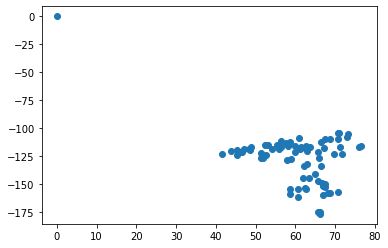

In [358]:
plt.scatter(data3.Latitude, data3.Longitude)

In [359]:
pos = {}
for i, v in data3.iterrows():
    pos[i] = (v.Latitude, v.Longitude)

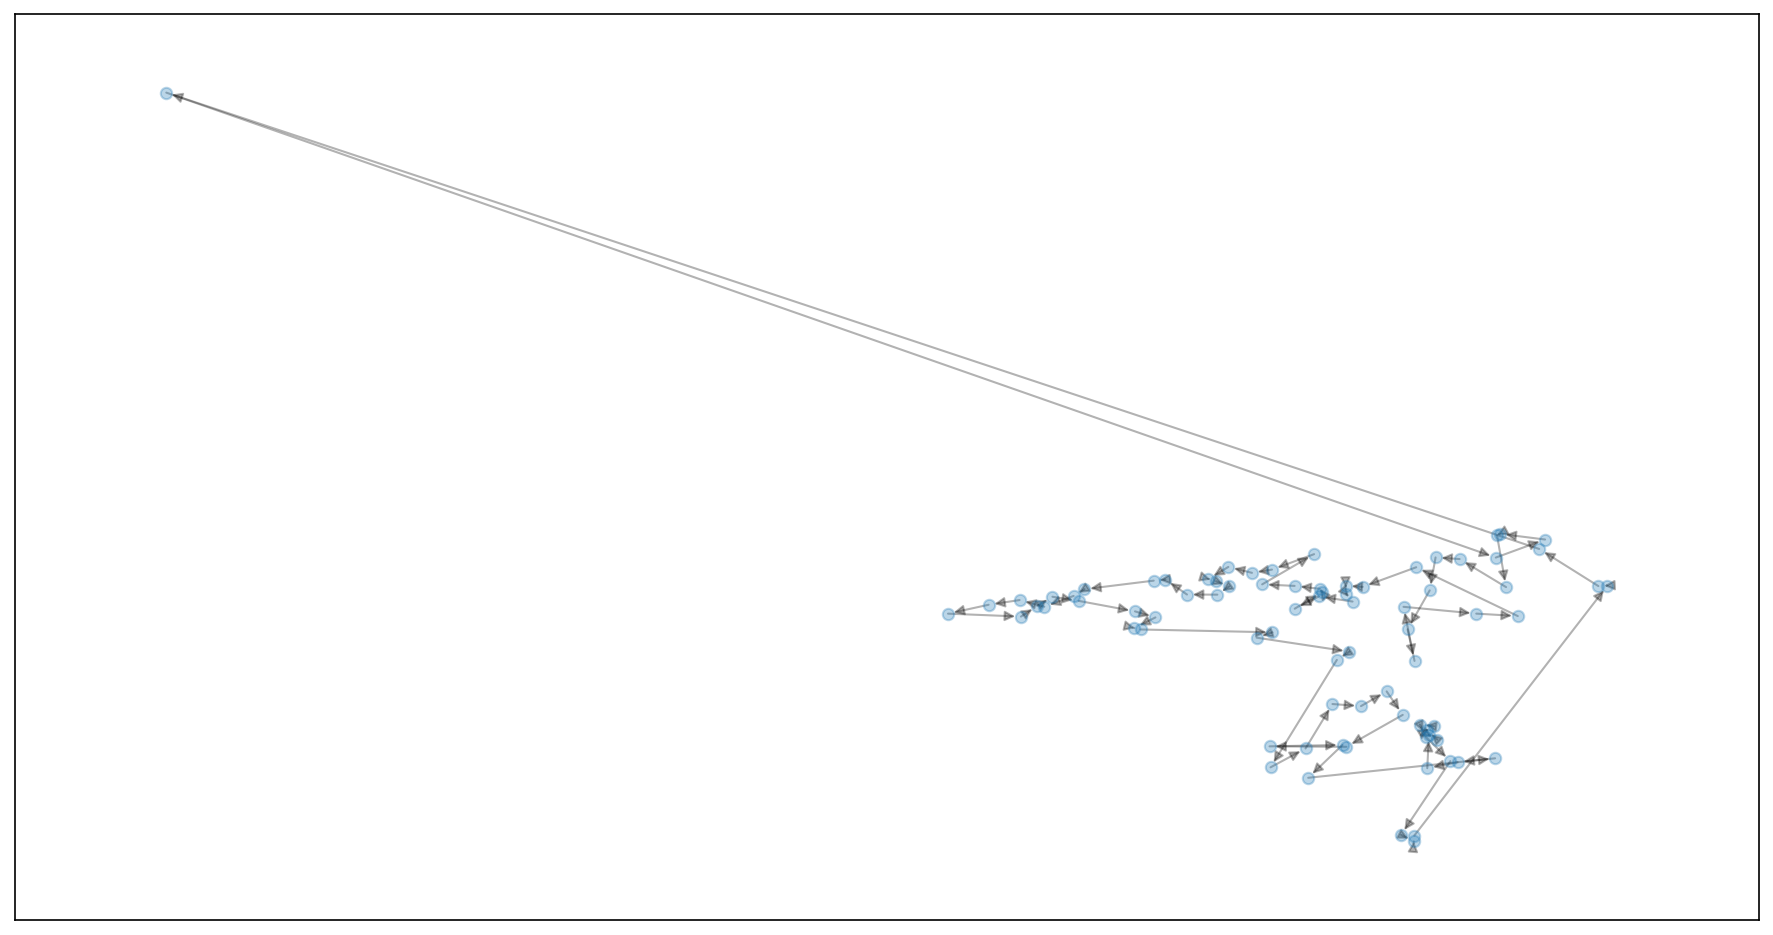

In [360]:
import networkx as nx
fig, ax = plt.subplots(dpi=150, figsize=(15,8))
G = nx.DiGraph()
G.add_nodes_from(pos.keys())
nx.add_path(G, line)
nx.draw_networkx(G, pos=pos, with_labels=False, node_size=30, linewidth=.5, ax=ax, alpha=.3)
plt.show()